In [3]:
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np

In [4]:
### read dataset
train = pd.read_csv("./input/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

## normalize and reshape the predictors  
train_x = train_x / 255

## create train and validation datasets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

## reshape the inputs
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

In [5]:
## recreate the train_x array and val_x array
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)

## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

In [6]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [7]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

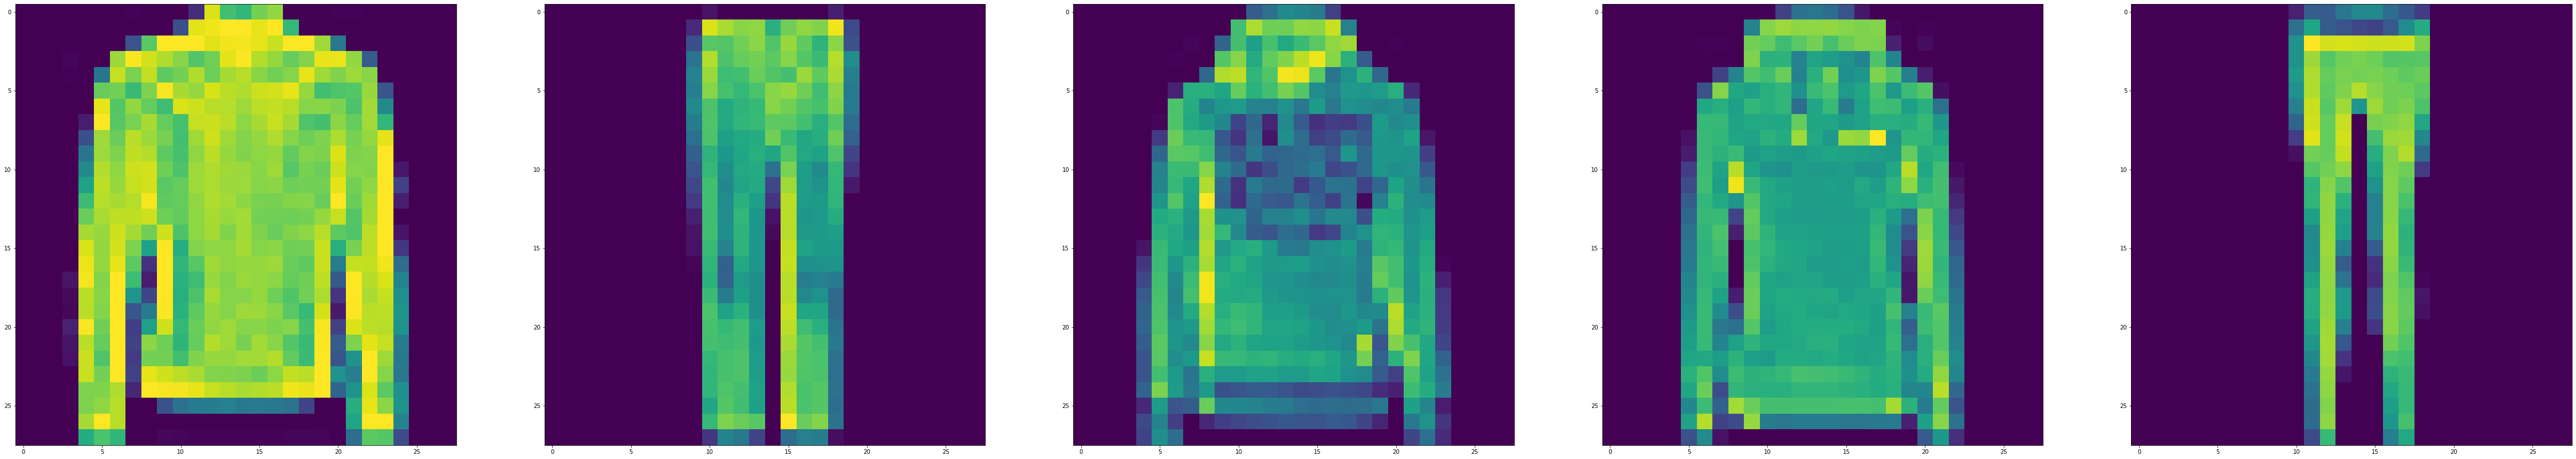

In [8]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i].reshape(28, 28))
plt.show()

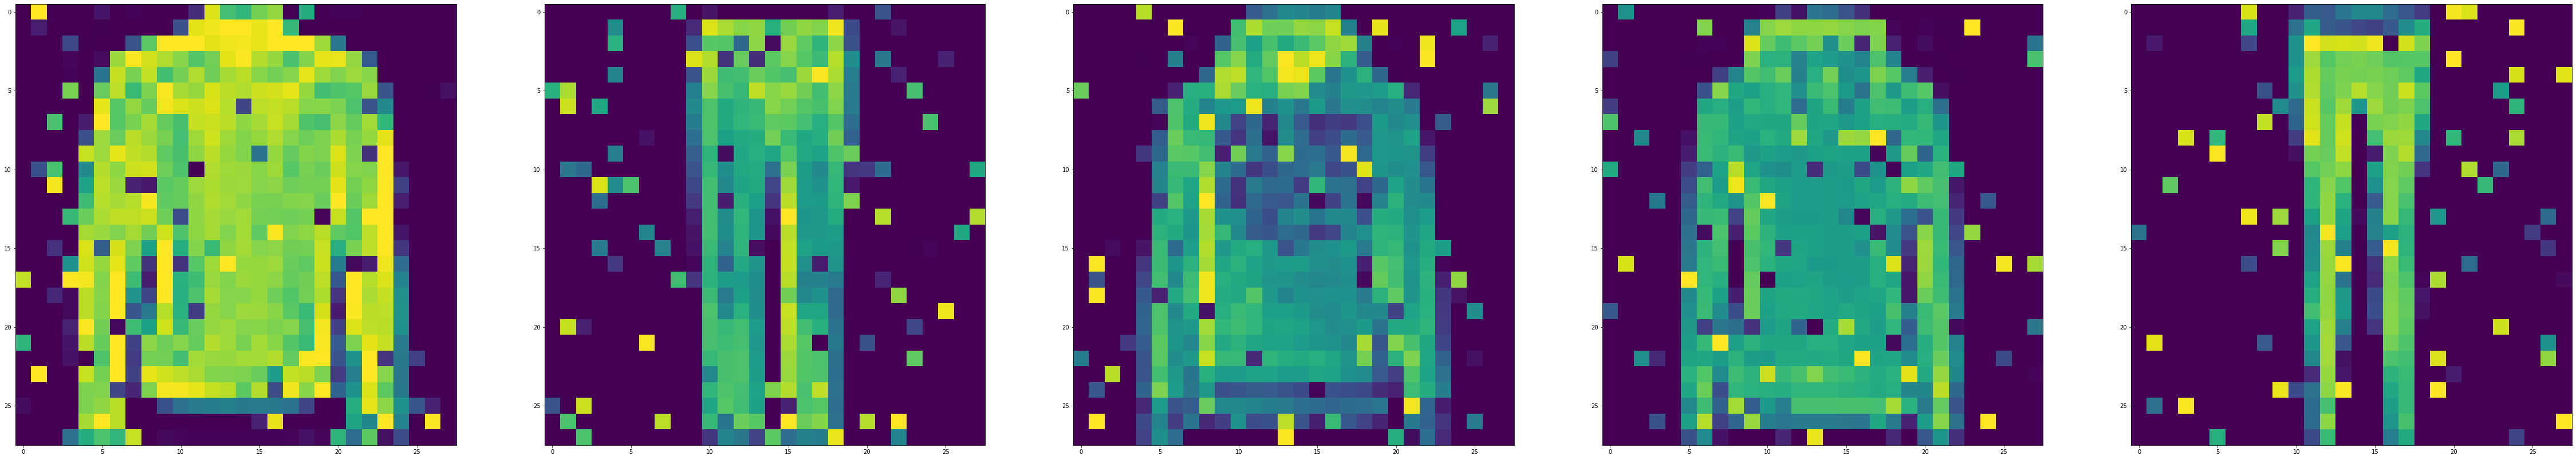

In [9]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(28, 28))
plt.show()

In [10]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

In [13]:
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0     

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model_2.fit(train_x_n, train_x, epochs=10, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])

Epoch 1/10
24/24 [==============================] - 89s 4s/step - loss: 0.1324 - val_loss: 0.0642
Epoch 2/10
24/24 [==============================] - 89s 4s/step - loss: 0.0556 - val_loss: 0.0404
Epoch 3/10
24/24 [==============================] - 90s 4s/step - loss: 0.0376 - val_loss: 0.0320
Epoch 4/10
24/24 [==============================] - 89s 4s/step - loss: 0.0308 - val_loss: 0.0277
Epoch 5/10
24/24 [==============================] - 88s 4s/step - loss: 0.0269 - val_loss: 0.0254
Epoch 6/10
24/24 [==============================] - 90s 4s/step - loss: 0.0248 - val_loss: 0.0235
Epoch 7/10
24/24 [==============================] - 90s 4s/step - loss: 0.0232 - val_loss: 0.0223
Epoch 8/10
24/24 [==============================] - 86s 4s/step - loss: 0.0221 - val_loss: 0.0215
Epoch 9/10
24/24 [==============================] - 88s 4s/step - loss: 0.0212 - val_loss: 0.0208
Epoch 10/10
24/24 [==============================] - 85s 4s/step - loss: 0.0206 - val_loss: 0.0201


In [ ]:
preds = model_2.predict(val_x_n[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(28, 28))
plt.show()